**Reinforcement Learning with TensorFlow & TRFL: Deep Q Network**
* Introduce the Deep Q Network (DQN) and its key parts
* Show how TRFL Q learning works with DQN
* Customize target network updating with TRFL's flexible usage

Outline:
1. Introduce CartPole
2. Introduce DQN
3. TRFL Q learning using DQN and loss output
4. Experience Replay
5. TRFL full target network updating: trfl.update_target_variables()
6. Partial updates with small tau: trfl.update_target_variables()
7. Periodic updates: trfl.periodic_target_update()




In [0]:
#TRFL works with TensorFlow 1.12
#installs TensorFlow version 1.12 then restarts the runtime
!pip install tensorflow==1.12

import os
os.kill(os.getpid(), 9)

In [1]:
#install TRFL
!pip install trfl==1.0

#install tensorflow-probability 0.5.0 that works with TensorFlow 1.12
!pip install tensorflow-probability==0.5.0

In [0]:
#tools for visualizing CartPole
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [0]:
import gym
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

** CartPole **

CartPole is an OpenAI gym environment (env). In CartPole you try to balance a pole on a cart by moving the cart left or right. If the pole falls below a certain angle or the cart moves too far right or left the episode is over. Each step the cart makes without failing, the agent recieves a reward of 1. CartPole is considered solved if the agent can reach 200 steps for 100 consecutive episodes.

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1001'] oserror=None return_code=0 stdout="" stderr="" timeout_happened=False>

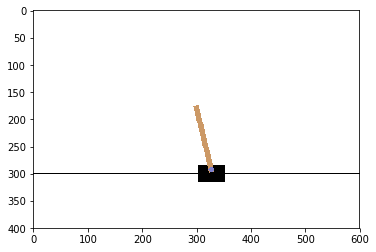

In [4]:
#visualization of Cartpole 
#code from here: https://colab.research.google.com/drive/16gZuQlwxmxR5ZWYLZvBeq3bTdFfb1r_6#scrollTo=6L4YayzR4FYj&forceEdit=true&offline=true&sandboxMode=true

display = Display(visible=0, size=(400, 300))
display.start()
env = gym.make("CartPole-v0")
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

for i in range(50):
  action = env.action_space.sample()
  obs, reward, done, info = env.step(action)
  screen = env.render(mode='rgb_array')
  
  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())

  if done:
    break
    
ipythondisplay.clear_output(wait=True)
env.close()
display.stop()

** Deep Q Network **

DQN was created by DeepMind researchers, achieving superhuman performance on many Atari games (https://deepmind.com/research/dqn/). What made the accomplishments of DQN even more impressive is that the DQN had nearly the same architecture and hyperparameter settings for each game (ie no game specific knowledge or set up) and the only inputs to the DQN were the screen pixels.

The main parts of the DQN are Q learning, the neural net, experience replay, and target network updating. For the neural net in this example, we replaced the Convolutional Neural Net (CNN) used in the original DQN with a 2 layer feed forward neural network (FFNN). We use the FFNN since CartPole doesn't give us image data and use CartPole in this example instead of Atari since Atari games take tens of millions of frames to train.

For an example of the DQN CNN in TensorFlow code see this link (https://github.com/dennybritz/reinforcement-learning/blob/master/DQN/Deep%20Q%20Learning%20Solution.ipynb). As opposed to many of the advanced CNNs used in image recognition, the DQN CNN (aka Nature CNN) is surprisingly simple. The DQN CNN only has 3 convolutional layers, no residual blocks, and no regularization yet is still widely used in Deep RL.

We'll discuss experience replay and target network updating later in this notebook. Next, let's go over a basic DQN NN architecture and show how we use TRFL Q learning to perform the updates.

In [0]:
# some of the TensorFlow code is this notebook is modified from this repo: https://github.com/udacity/deep-learning/blob/master/reinforcement/Q-learning-cart.ipynb

import trfl

class QNetwork:
    def __init__(self, name, learning_rate=0.01, state_size=4, 
                 action_size=2, hidden_size=10, batch_size=20):
        with tf.variable_scope(name):
            #set up tensors
            self.input_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            self.action_ = tf.placeholder(tf.int32, [batch_size], name='actions')
            self.targetQ_ = tf.placeholder(tf.float32, [batch_size, action_size], name='target')
            self.reward_ = tf.placeholder(tf.float32,[batch_size],name="reward")
            self.discount_ = tf.constant(0.99,shape=[batch_size],dtype=tf.float32,name="discount")
            self.name = name
   
            #This is the Neural Network. For CNN implementation, the input would feed into a CNN layer prior to these layers.
            self.fc1 = tf.contrib.layers.fully_connected(self.input_, hidden_size, activation_fn=tf.nn.relu)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size, activation_fn=tf.nn.relu)
            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, activation_fn=None)

            #TRFL qlearning
            qloss, q_learning = trfl.qlearning(self.output, self.action_, self.reward_, self.discount_, self.targetQ_)
            self.loss = tf.reduce_mean(qloss)
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)
            
    def get_qnetwork_variables(self):
      return [t for t in tf.trainable_variables() if t.name.startswith(self.name)]

In [0]:
# define hyperparameters
train_episodes = 1000           # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# epsilon greedy parameters
epsilon_start = 1.0            # exploration probability at start
epsilon_min = 0.01            # minimum exploration probability
epsilon_step = (epsilon_start-epsilon_min)/train_episodes

# network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

# how often in steps to update target network 
update_target_every = 2000

#declare TRFL in graph
tf.reset_default_graph()
trainQN = QNetwork(name='train_qn', hidden_size=hidden_size, learning_rate=learning_rate,batch_size=batch_size)
targetQN = QNetwork(name='target_qn', hidden_size=hidden_size, learning_rate=learning_rate,batch_size=batch_size)

** TRFL Usage **

While TRFL usage appears a bit different in this example, we still follow the same outline as in section 1. We define the tensors and TRFL tensors in the graph. In this example we define the tensors in the QNetwork class and then create an instance of the class and run TRFL in the session below. Note how we use the loss output from trfl.qlearning(). We take the loss and minimize it with the gradient descent optimizer Adam on batches of tensors. This is standard qlearning usage in Deep RL (as opposed to Section 1 where we used the td error on batch_size = 1, tabular updates).

Another key difference between Section 1 is that in Deep RL we use function approximators to estimate Q values. In the trfl.qlearning() function we input the NN output (self.output) for the current Q value. For the Q value at the next state we use the self.targetQs tensor, which is the output of the targetQN network. More on this in target network updating section.

** DQN: Experience Replay **

Q learning is an off-policy method. In off-policy methods we often save samples and then train on them. DQN has a memory buffer that stores state, action, reward, and next state samples. In the training loop, DQN will sample from this memory buffer and train on the saved samples.


In [0]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

In [0]:
# Initialize the simulation
env = gym.make("CartPole-v0")
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

** DQN: Target Network Updating with trfl.update_target_variables()**

DQN has two networks: a train network and a target network. The target network provides the next-state action values for the Q learning update. We use the next-state action values to update the train network. Periodically we then update target network variables with the train network variables. We'll see three different TRFL ways to update the target variables in this notebook. Using a target network increases stability and convergence of the DQN.

The TRFL method update_target_variables() updates the target variables with the source variables. In this case we fully replace the target network variables with the train network variables (tau=1.0). To update target variables in TRFL, input the target and source variables into trfl.update_target_variables() in the graph. In the session call this operation every so often (we call it every 2000 steps in this example). In the next example we'll do incremental variable updates (tau < 1) and in the last example do periodic updates.

In [0]:
#TRFL way
target_network_update_ops = trfl.update_target_variables(targetQN.get_qnetwork_variables(), 
                                                         trainQN.get_qnetwork_variables(),tau=1.0)

#Non TRFL way of doing full updates (tau=1.0)
#copies the trainQN values to the targetQN
#from Denny Britz's RL repo
#https://github.com/dennybritz/reinforcement-learning/blob/master/DQN/Double%20DQN%20Solution.ipynb

# def copy_model_parameters(sess, estimator1, estimator2):
#     """
#     Copies the model parameters of one estimator to another.

#     Args:
#       sess: Tensorflow session instance
#       estimator1: Estimator to copy the paramters from
#       estimator2: Estimator to copy the parameters to
#     """
#     e1_params = [t for t in tf.trainable_variables() if t.name.startswith(estimator1.name)]
#     e1_params = sorted(e1_params, key=lambda v: v.name)
#     e2_params = [t for t in tf.trainable_variables() if t.name.startswith(estimator2.name)]
#     e2_params = sorted(e2_params, key=lambda v: v.name)

#     update_ops = []
#     for e1_v, e2_v in zip(e1_params, e2_params):
#         op = e2_v.assign(e1_v)
#         update_ops.append(op)

#     sess.run(update_ops)

In [10]:
rewards_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    epsilon = 1.0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        # stop training when agent is consistently getting high rewards
        if len(rewards_list) > 9 and np.mean(rewards_list[-10:],axis=0)[1] > 195:
          print("Stopping at episode {} with average rewards of {} in last 10 episodes".
                format(ep,np.mean(rewards_list[-10:],axis=0)[1]))
          break
        while t < max_steps:
            step += 1
            
            # update target q network
            if step % update_target_every == 0:
                #TRFL way
                sess.run(target_network_update_ops)
                print("\nCopied model parameters to target network.")
                #pure TensorFlow way
                #copy_model_parameters(sess, trainQN, targetQN)
            
            # epsilon greedy exploration
            if np.random.rand() <= epsilon:
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {trainQN.input_: state.reshape((1, *state.shape))}
                action_values = sess.run(trainQN.output, feed_dict=feed)
                action = np.argmax(action_values)
            
            # take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                if ep % 10 == 0:
                  print('Episode: {}'.format(ep),
                        'Total reward: {}'.format(total_reward),
                        'Training loss: {:.4f}'.format(loss),
                        'Epsilon: {:.4f}'.format(epsilon))
                rewards_list.append((ep, total_reward))
                
                
                # add experience to memory
                memory.add((state, action, reward, next_state))
                
                # start new episode
                env.reset()
                # take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

                # epsilon greedy exploration
                epsilon -= epsilon_step
                if epsilon < epsilon_min:
                  epsilon = epsilon_min
                  
            else:
                # add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # train network
            #in this example (and in Deep Q Networks) use targetQN for the target values
            target_Qs = sess.run(targetQN.output, feed_dict={targetQN.input_: next_states})
            # set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)
            
            # TRFL way, calculate td_error within TRFL
            loss, _ = sess.run([trainQN.loss, trainQN.opt],
                                feed_dict={trainQN.input_: states,
                                           trainQN.targetQ_: target_Qs,
                                           trainQN.reward_: rewards,
                                           trainQN.action_: actions})

Episode: 10 Total reward: 10.0 Training loss: 0.3170 Epsilon: 0.9911
Episode: 20 Total reward: 16.0 Training loss: 0.1028 Epsilon: 0.9812
Episode: 30 Total reward: 68.0 Training loss: 0.0574 Epsilon: 0.9713
Episode: 40 Total reward: 42.0 Training loss: 0.0206 Epsilon: 0.9614
Episode: 50 Total reward: 38.0 Training loss: 0.0049 Epsilon: 0.9515
Episode: 60 Total reward: 12.0 Training loss: 0.0014 Epsilon: 0.9416
Episode: 70 Total reward: 21.0 Training loss: 0.0024 Epsilon: 0.9317
Episode: 80 Total reward: 35.0 Training loss: 0.0032 Epsilon: 0.9218
Episode: 90 Total reward: 13.0 Training loss: 0.0007 Epsilon: 0.9119

Copied model parameters to target network.
Episode: 100 Total reward: 13.0 Training loss: 0.0835 Epsilon: 0.9020
Episode: 110 Total reward: 12.0 Training loss: 0.0631 Epsilon: 0.8921
Episode: 120 Total reward: 26.0 Training loss: 0.0052 Epsilon: 0.8822
Episode: 130 Total reward: 17.0 Training loss: 0.0600 Epsilon: 0.8723
Episode: 140 Total reward: 18.0 Training loss: 0.0319 E

Text(0, 0.5, 'Total Reward')

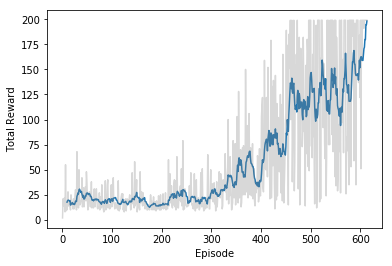

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

** Example 2: Incremental Variable Updates **
* Benefit of TRFL with target updating is you can quickly and easily switch between different update types
* Let's do the same example except instead of full target variable updates (tau=1.0) do an incremental update (tau=1/2000)
* While the original DQN used full target variable updates, many algorithms use the incremental update method


In [0]:
# define hyperparameters
train_episodes = 1000           # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# epsilon greedy parameters
epsilon_start = 1.0            # exploration probability at start
epsilon_min = 0.01            # minimum exploration probability
epsilon_step = (epsilon_start-epsilon_min)/train_episodes

# network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

# how often in steps to update target network 
update_target_every = 2000

#declare TRFL in graph
tf.reset_default_graph()
trainQN = QNetwork(name='train_qn', hidden_size=hidden_size, learning_rate=learning_rate,batch_size=batch_size)
targetQN = QNetwork(name='target_qn', hidden_size=hidden_size, learning_rate=learning_rate,batch_size=batch_size)

# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

In [0]:
# TRFL way using incremental target variable updating
# change tau=1.0 into a number between 0 and 1 in the graph and in sess.run() update the target network 
  #every training step (rather than every 2000 steps)
target_network_update_ops = trfl.update_target_variables(targetQN.get_qnetwork_variables(),
                                                         trainQN.get_qnetwork_variables(),tau=1.0/update_target_every)

# last example TRFL way
#target_network_update_ops = trfl.update_target_variables(targetQN.get_qnetwork_variables(), 
#trainQN.get_qnetwork_variables(),tau=1.0)

In [14]:
rewards_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    epsilon = 1.0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        # stop training when agent is consistently getting high rewards
        if len(rewards_list) > 9 and np.mean(rewards_list[-10:],axis=0)[1] > 195:
          print("Stopping at episode {} with average rewards of {} in last 10 episodes".
                format(ep,np.mean(rewards_list[-10:],axis=0)[1]))
          break
        while t < max_steps:
            step += 1
            
            # update target q network  
            sess.run(target_network_update_ops)
            # prior way of target network upating
#             if step % update_target_every == 0:
#                 sess.run(target_network_update_ops)
#                 print("\nCopied model parameters to target network.")
            
            # epsilon greedy exploration
            if np.random.rand() <= epsilon:
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {trainQN.input_: state.reshape((1, *state.shape))}
                action_values = sess.run(trainQN.output, feed_dict=feed)
                action = np.argmax(action_values)
            
            # take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                if ep % 10 == 0:
                  print('Episode: {}'.format(ep),
                        'Total reward: {}'.format(total_reward),
                        'Training loss: {:.4f}'.format(loss),
                        'Epsilon: {:.4f}'.format(epsilon))
                rewards_list.append((ep, total_reward))
                
                
                # add experience to memory
                memory.add((state, action, reward, next_state))
                
                # start new episode
                env.reset()
                # take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

                # epsilon greedy exploration
                epsilon -= epsilon_step
                if epsilon < epsilon_min:
                  epsilon = epsilon_min
                  
            else:
                # add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # train network
            #in this example (and in Deep Q Networks) use targetQN for the target values
            target_Qs = sess.run(targetQN.output, feed_dict={targetQN.input_: next_states})
            # set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)
            
            # TRFL way, calculate td_error within TRFL
            loss, _ = sess.run([trainQN.loss, trainQN.opt],
                                feed_dict={trainQN.input_: states,
                                           trainQN.targetQ_: target_Qs,
                                           trainQN.reward_: rewards,
                                           trainQN.action_: actions})

Episode: 10 Total reward: 40.0 Training loss: 0.1491 Epsilon: 0.9911
Episode: 20 Total reward: 29.0 Training loss: 0.0405 Epsilon: 0.9812
Episode: 30 Total reward: 9.0 Training loss: 0.0166 Epsilon: 0.9713
Episode: 40 Total reward: 12.0 Training loss: 0.0093 Epsilon: 0.9614
Episode: 50 Total reward: 19.0 Training loss: 0.0017 Epsilon: 0.9515
Episode: 60 Total reward: 14.0 Training loss: 0.0026 Epsilon: 0.9416
Episode: 70 Total reward: 32.0 Training loss: 0.0016 Epsilon: 0.9317
Episode: 80 Total reward: 17.0 Training loss: 0.0007 Epsilon: 0.9218
Episode: 90 Total reward: 20.0 Training loss: 0.0022 Epsilon: 0.9119
Episode: 100 Total reward: 20.0 Training loss: 0.0003 Epsilon: 0.9020
Episode: 110 Total reward: 24.0 Training loss: 0.0008 Epsilon: 0.8921
Episode: 120 Total reward: 14.0 Training loss: 0.0022 Epsilon: 0.8822
Episode: 130 Total reward: 7.0 Training loss: 0.0062 Epsilon: 0.8723
Episode: 140 Total reward: 18.0 Training loss: 0.0064 Epsilon: 0.8624
Episode: 150 Total reward: 10.0

Text(0, 0.5, 'Total Reward')

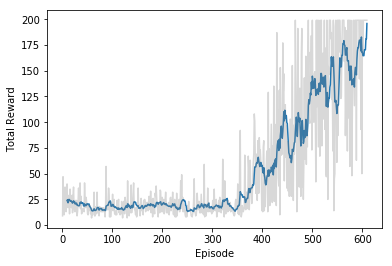

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

** Example 3: Periodic Target Update **
* trfl.periodic_target_update() will periodically update the target variables
* In the first example, we updated the target variables by calling the TRFL operation every so often (*if step % update_target_every == 0*)
* By using trfl.periodic_target_update() we no longer need that line of code. 
* Some algorithms, don't update the target networks every step (for example TD3  https://spinningup.openai.com/en/latest/algorithms/td3.html)
* trfl.periodically() is used in trfl.periodic_target_update() but can also be used independently to periodically update the operations of your choice.


In [0]:
# define hyperparameters
train_episodes = 1000           # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# epsilon greedy parameters
epsilon_start = 1.0            # exploration probability at start
epsilon_min = 0.01            # minimum exploration probability
epsilon_step = (epsilon_start-epsilon_min)/train_episodes

# network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

# how often in steps to update target network 
update_target_every = 2000

#declare TRFL in graph
tf.reset_default_graph()
trainQN = QNetwork(name='train_qn', hidden_size=hidden_size, learning_rate=learning_rate,batch_size=batch_size)
targetQN = QNetwork(name='target_qn', hidden_size=hidden_size, learning_rate=learning_rate,batch_size=batch_size)

# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

In [0]:
# TRFL example using periodic_target_update
target_network_update_ops = trfl.periodic_target_update(targetQN.get_qnetwork_variables(),trainQN.get_qnetwork_variables(),
                                                                    update_period=update_target_every,tau=1.0)

#TRFL Example 2
#simply change tau=1.0 into a number between 0 and 1 in the graph and in sess.run() 
  #update the target network every training step (rather than every 2000 steps)
#update every step with incremental update
#target_network_update_ops = trfl.update_target_variables(targetQN.get_qnetwork_variables(),
#trainQN.get_qnetwork_variables(),tau=1.0/update_target_every)

#TRFL Example 1
#target_network_update_ops = trfl.update_target_variables(targetQN.get_qnetwork_variables(),
#trainQN.get_qnetwork_variables(),tau=1.0)

In [18]:
rewards_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    epsilon = 1.0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        # stop training when agent is consistently getting high rewards
        if len(rewards_list) > 9 and np.mean(rewards_list[-10:],axis=0)[1] > 195:
          print("Stopping at episode {} with average rewards of {} in last 10 episodes".
                format(ep,np.mean(rewards_list[-10:],axis=0)[1]))
          break
        while t < max_steps:
            step += 1
            
            #update target q network
            sess.run(target_network_update_ops)
            # prior way of target network upating
#             if step % update_target_every == 0:
#                 sess.run(target_network_update_ops)
#                 print("\nCopied model parameters to target network.")

            
            # epsilon greedy exploration
            if np.random.rand() <= epsilon:
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {trainQN.input_: state.reshape((1, *state.shape))}
                action_values = sess.run(trainQN.output, feed_dict=feed)
                action = np.argmax(action_values)
            
            # take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                if ep % 10 == 0:
                  print('Episode: {}'.format(ep),
                        'Total reward: {}'.format(total_reward),
                        'Training loss: {:.4f}'.format(loss),
                        'Epsilon: {:.4f}'.format(epsilon))
                rewards_list.append((ep, total_reward))
                
                
                # add experience to memory
                memory.add((state, action, reward, next_state))
                
                # start new episode
                env.reset()
                # take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

                # epsilon greedy exploration
                epsilon -= epsilon_step
                if epsilon < epsilon_min:
                  epsilon = epsilon_min
                  
            else:
                # add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # train network
            #in this example (and in Deep Q Networks) use targetQN for the target values
            target_Qs = sess.run(targetQN.output, feed_dict={targetQN.input_: next_states})
            # set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)
            
            # TRFL way, calculate td_error within TRFL
            loss, _ = sess.run([trainQN.loss, trainQN.opt],
                                feed_dict={trainQN.input_: states,
                                           trainQN.targetQ_: target_Qs,
                                           trainQN.reward_: rewards,
                                           trainQN.action_: actions})

Episode: 10 Total reward: 42.0 Training loss: 0.2210 Epsilon: 0.9911
Episode: 20 Total reward: 57.0 Training loss: 0.0712 Epsilon: 0.9812
Episode: 30 Total reward: 41.0 Training loss: 0.0654 Epsilon: 0.9713
Episode: 40 Total reward: 14.0 Training loss: 0.0171 Epsilon: 0.9614
Episode: 50 Total reward: 20.0 Training loss: 0.0060 Epsilon: 0.9515
Episode: 60 Total reward: 19.0 Training loss: 0.0015 Epsilon: 0.9416
Episode: 70 Total reward: 24.0 Training loss: 0.0008 Epsilon: 0.9317
Episode: 80 Total reward: 29.0 Training loss: 0.0030 Epsilon: 0.9218
Episode: 90 Total reward: 15.0 Training loss: 0.0005 Epsilon: 0.9119
Episode: 100 Total reward: 94.0 Training loss: 0.0079 Epsilon: 0.9020
Episode: 110 Total reward: 50.0 Training loss: 0.0545 Epsilon: 0.8921
Episode: 120 Total reward: 10.0 Training loss: 0.0253 Epsilon: 0.8822
Episode: 130 Total reward: 23.0 Training loss: 0.0037 Epsilon: 0.8723
Episode: 140 Total reward: 33.0 Training loss: 0.0202 Epsilon: 0.8624
Episode: 150 Total reward: 21

Text(0, 0.5, 'Total Reward')

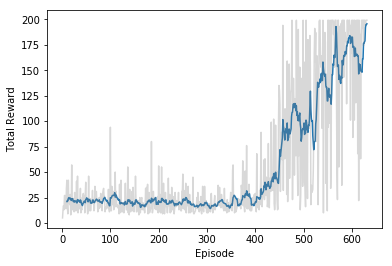

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')